In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='1'

np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 32

In [3]:
%load_ext autoreload
%autoreload 2

# Tetris block classification


<img src = "https://i.imgur.com/ZwfnL78.png">

## I. Preparation

- Make tetris dataset (data_num, batch_size, random_position, random_scale, random_rotation)
> a. Image size == 32  
> b. Block size == 12

- Visualize dataset for variable arguments settings

In [4]:
basic_block = {
    'type0': np.array(
        [[0,0,0,0],
         [0,1,1,0],
         [0,1,1,0],
         [0,0,0,0]]
    ),
    'type1': np.array(
        [[0,0,0,0],
         [0,1,0,0],
         [1,1,1,0],
         [0,0,0,0]]
    ),
    'type2': np.array(
        [[0,1,0,0],
         [0,1,1,0],
         [0,0,1,0],
         [0,0,0,0]]
    ),
    'type3': np.array(
        [[0,0,1,0],
         [0,1,1,0],
         [0,1,0,0],
         [0,0,0,0]]
    ),
    'type4': np.array(
        [[0,1,0,0],
         [0,1,0,0],
         [0,1,0,0],
         [0,1,0,0]]
    ),
    'type5': np.array(
        [[0,0,0,0],
         [0,1,0,0],
         [0,1,0,0],
         [0,1,1,0]]
    ),
    'type6': np.array(
        [[0,0,0,0],
         [0,0,1,0],
         [0,0,1,0],
         [0,1,1,0]]
    )
}


def convert_to_block_image(block):
    block = Image.fromarray(np.array(block*255, dtype=np.uint8))
    return block


def resize_block(block, block_size):
    block = block.resize((block_size, block_size))
    return block


def get_block_image(block_size, block_type):
    
    block = basic_block['type{}'.format(block_type)]
    block = convert_to_block_image(block)
    block = resize_block(block, block_size)
    return block, block_type


def get_random_position(img_size, block_size):
    x, y = np.random.choice(img_size - block_size), np.random.choice(img_size - block_size)
    return x, y


def get_tetris_sample(img_size, block_type, 
                      random_position=True, 
                      random_scale=False, 
                      random_rotation=False):
    
    if random_scale:
        block_size = np.random.choice([4, 8, 12, 16])
    else:
        block_size = 12
        
    block, label = get_block_image(block_size, block_type)
    
    if random_rotation:
        k = np.random.randint(4)
        block = np.rot90(block, k)
        
    if random_position:
        x, y = get_random_position(img_size, block_size)
    else:
        mid = (img_size-block_size)//2
        x, y = mid, mid
        
    data = np.zeros((img_size, img_size), dtype=np.uint8)
    data[y:y+block_size, x:x+block_size] = block
    
    return data, label


def make_tetris_dataset(N, batch_size, random_position, random_scale, random_rotation):
    
    images, labels = [], []
    block_type_num = len(basic_block)
    
    for i in range(N//batch_size):
        image_batch, label_batch = [], []
        for j in range(batch_size):
            block_type = np.random.choice(block_type_num)
            image, label = get_tetris_sample(img_size, block_type,
                                             random_position=random_position,
                                             random_scale=random_scale,
                                             random_rotation=random_rotation)
            image_batch.append(image)
            label_batch.append(label)
            
        images.append(image_batch)
        labels.append(label_batch)
        
    images = np.array(images).reshape(N//batch_size, batch_size, img_size, img_size)
    labels = np.array(labels).reshape(N//batch_size, batch_size)
    return images, labels


def visualize_dataset(dataset, num):
    plt.figure(figsize=(num,3))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(dataset[0][i][0])
        plt.axis('off')
        plt.title('type {}'.format(dataset[1][i][0]))

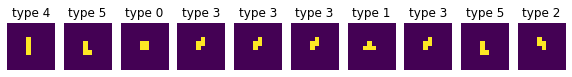

In [5]:
plot_num = 10
random_position = False
random_scale = False
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

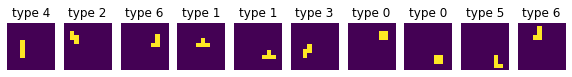

In [6]:
plot_num = 10
random_position = True
random_scale = False
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

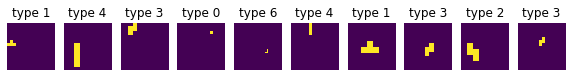

In [7]:
plot_num = 10
random_position = True
random_scale = True
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

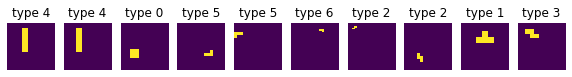

In [8]:
plot_num = 10
random_position = True
random_scale = True
random_rotation = True
dataset = make_tetris_dataset(plot_num, 1, random_position, random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

## II. MultiLayer Perceptrons (MLP)
### Multilayer Perceptron using Pytorch with below conditions


> a. architecture : Linear(50) - ReLU - Linear(25) - ReLU - Linear(7)  
> b. Train set
> - D1 = tetris_dataset(N=2000, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
> - D2 = tetris_dataset(N=500, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
> - D3 = tetris_dataset(N=100, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
>
> c. Test set
> - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)
> 
> d. Epochs
> - 300 for training on D1
> - 600 for training on D2
> - 1200 for training on D3
>
> e. Loss function = CrossEntropyLoss(reduction='mean')

- Plot test accuracy per train number

In [9]:
class TetrisMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=1024, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=25)
        self.fc3 = nn.Linear(in_features=25, out_features=7)

    def forward(self, x):
        x = x.view(-1, img_size * img_size)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
def get_accuracy(pred, label):
    return torch.sum(pred == label).item() / len(label)


def get_prediction(output):
    return torch.argmax(output, axis=1)

    
def train(model, optimizer, criterion, train_dataset, total_epoch):
    
    model.train()
    
    for epoch in range(1, total_epoch+1):
        for image_batch, label_batch in zip(*train_dataset):
            image_batch = torch.Tensor(image_batch) / 255.
            label_batch = torch.LongTensor(label_batch)

            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            loss = 0
            
            optimizer.zero_grad()
            output = model(image_batch)
            loss = criterion(output, label_batch)
            loss.backward()
            optimizer.step()
            
        if epoch % 50 == 0 or epoch == 1:
            pred = get_prediction(output)
            train_accuracy = get_accuracy(pred, label_batch)
            print('Epoch:{}, Loss:{}, Train Accuracy:{}'.format(epoch, loss.item(), train_accuracy))

            
def evaluate(model, criterion, test_dataset):
    
    model.eval()
    test_accuracy = 0
    
    for image_batch, label_batch in zip(*test_dataset):
        image_batch = torch.Tensor(image_batch) / 255.
        label_batch = torch.LongTensor(label_batch)
        
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        output = model(image_batch)
        pred = get_prediction(output)
        test_accuracy += get_accuracy(pred, label_batch)
        
    test_accuracy /= (len(test_dataset[0]))
    
    return test_accuracy

In [10]:
batch_size = 20
random_position = True
random_scale = False
random_rotation = False

train_num = 2000
D1 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

train_num = 1000
D2 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

train_num = 500
D3 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

test_num = 200
E1 = make_tetris_dataset(test_num, batch_size, random_position, random_scale, random_rotation)

In [11]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 300
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=D1, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:1.1770379543304443, Train Accuracy:0.65
Epoch:50, Loss:0.0005044132703915238, Train Accuracy:1.0
Epoch:100, Loss:0.00020420104556251317, Train Accuracy:1.0
Epoch:150, Loss:0.00012526809587143362, Train Accuracy:1.0
Epoch:200, Loss:8.893311314750463e-05, Train Accuracy:1.0
Epoch:250, Loss:6.828307959949598e-05, Train Accuracy:1.0
Epoch:300, Loss:5.517602039617486e-05, Train Accuracy:1.0
0.9799999999999999


In [12]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 600
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=D2, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:1.826340913772583, Train Accuracy:0.25
Epoch:50, Loss:0.0009358167881146073, Train Accuracy:1.0
Epoch:100, Loss:0.00025060176267288625, Train Accuracy:1.0
Epoch:150, Loss:0.0001472711592214182, Train Accuracy:1.0
Epoch:200, Loss:0.00010328293137717992, Train Accuracy:1.0
Epoch:250, Loss:7.886886305641383e-05, Train Accuracy:1.0
Epoch:300, Loss:6.347894668579102e-05, Train Accuracy:1.0
Epoch:350, Loss:5.316734313964844e-05, Train Accuracy:1.0
Epoch:400, Loss:4.570484088617377e-05, Train Accuracy:1.0
Epoch:450, Loss:3.99589553126134e-05, Train Accuracy:1.0
Epoch:500, Loss:3.546476364135742e-05, Train Accuracy:1.0
Epoch:550, Loss:3.160238338750787e-05, Train Accuracy:1.0
Epoch:600, Loss:2.866983413696289e-05, Train Accuracy:1.0
0.8550000000000001


In [13]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 1200
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=D3, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:2.0023725032806396, Train Accuracy:0.25
Epoch:50, Loss:0.002888798713684082, Train Accuracy:1.0
Epoch:100, Loss:0.0010238647228106856, Train Accuracy:1.0
Epoch:150, Loss:0.0005818128702230752, Train Accuracy:1.0
Epoch:200, Loss:0.0003952980041503906, Train Accuracy:1.0
Epoch:250, Loss:0.0002955198287963867, Train Accuracy:1.0
Epoch:300, Loss:0.00022736788378097117, Train Accuracy:1.0
Epoch:350, Loss:0.00018322467803955078, Train Accuracy:1.0
Epoch:400, Loss:0.0001533985196147114, Train Accuracy:1.0
Epoch:450, Loss:0.00013152361498214304, Train Accuracy:1.0
Epoch:500, Loss:0.0001142501860158518, Train Accuracy:1.0
Epoch:550, Loss:0.00010077953629661351, Train Accuracy:1.0
Epoch:600, Loss:8.993149094749242e-05, Train Accuracy:1.0
Epoch:650, Loss:8.072853233898059e-05, Train Accuracy:1.0
Epoch:700, Loss:7.319450378417969e-05, Train Accuracy:1.0
Epoch:750, Loss:6.68525681248866e-05, Train Accuracy:1.0
Epoch:800, Loss:6.141662743175402e-05, Train Accuracy:1.0
Epoch:850, Loss:5

In [14]:
img_size = 32
summary(mlp, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          51,250
            Linear-2                   [-1, 25]           1,275
            Linear-3                    [-1, 7]             182
Total params: 52,707
Trainable params: 52,707
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [15]:
batch_size = 20
random_position = True
random_scale = False
random_rotation = False
mlp_test_accuracy = []

mlp_test_num = 200
E = make_tetris_dataset(test_num, batch_size, random_position, random_scale, random_rotation)

for i in range(100, 2100, 100):
    print('')
    print('**** Train number : {} ****'.format(i))
    train_num = i
    D = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

    mlp = TetrisMLP()
    mlp.to(device)

    learning_rate = 0.05
    optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')

    total_epoch = 600000//i
    train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=D, total_epoch=total_epoch)

    accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=E)
    mlp_test_accuracy.append(accuracy)


**** Train number : 100 ****
Epoch:1, Loss:1.9921226501464844, Train Accuracy:0.05
Epoch:50, Loss:0.0019675851799547672, Train Accuracy:1.0
Epoch:100, Loss:0.000761139381211251, Train Accuracy:1.0
Epoch:150, Loss:0.0004517316701821983, Train Accuracy:1.0
Epoch:200, Loss:0.0003139615000691265, Train Accuracy:1.0
Epoch:250, Loss:0.0002390146255493164, Train Accuracy:1.0
Epoch:300, Loss:0.00019091367721557617, Train Accuracy:1.0
Epoch:350, Loss:0.00015828610048629344, Train Accuracy:1.0
Epoch:400, Loss:0.00013471841521095484, Train Accuracy:1.0
Epoch:450, Loss:0.00011699199967551976, Train Accuracy:1.0
Epoch:500, Loss:0.00010300874419044703, Train Accuracy:1.0
Epoch:550, Loss:9.188651893055066e-05, Train Accuracy:1.0
Epoch:600, Loss:8.194446854759008e-05, Train Accuracy:1.0
Epoch:650, Loss:7.433891005348414e-05, Train Accuracy:1.0
Epoch:700, Loss:6.804466102039441e-05, Train Accuracy:1.0
Epoch:750, Loss:6.272792961681262e-05, Train Accuracy:1.0
Epoch:800, Loss:5.819797661388293e-05, Trai

Epoch:900, Loss:2.2220610844669864e-05, Train Accuracy:1.0
Epoch:950, Loss:2.0384788513183594e-05, Train Accuracy:1.0
Epoch:1000, Loss:1.8858909243135713e-05, Train Accuracy:1.0
Epoch:1050, Loss:1.761913335940335e-05, Train Accuracy:1.0
Epoch:1100, Loss:1.6474723452120088e-05, Train Accuracy:1.0
Epoch:1150, Loss:1.5568733942927793e-05, Train Accuracy:1.0
Epoch:1200, Loss:1.4543533325195312e-05, Train Accuracy:1.0
Epoch:1250, Loss:1.3899802979722153e-05, Train Accuracy:1.0
Epoch:1300, Loss:1.3089180356473662e-05, Train Accuracy:1.0
Epoch:1350, Loss:1.2493133908719756e-05, Train Accuracy:1.0
Epoch:1400, Loss:1.19447704491904e-05, Train Accuracy:1.0
Epoch:1450, Loss:1.1467933290987276e-05, Train Accuracy:1.0
Epoch:1500, Loss:1.09434131445596e-05, Train Accuracy:1.0
Epoch:1550, Loss:1.0538101378188003e-05, Train Accuracy:1.0
Epoch:1600, Loss:1.010894811770413e-05, Train Accuracy:1.0
Epoch:1650, Loss:9.822845640883315e-06, Train Accuracy:1.0
Epoch:1700, Loss:9.393692380399443e-06, Train Acc

Epoch:1150, Loss:2.8204918635310605e-05, Train Accuracy:1.0
Epoch:1200, Loss:2.677440716070123e-05, Train Accuracy:1.0

**** Train number : 600 ****
Epoch:1, Loss:2.0044312477111816, Train Accuracy:0.15
Epoch:50, Loss:0.0017947793239727616, Train Accuracy:1.0
Epoch:100, Loss:0.0006564855575561523, Train Accuracy:1.0
Epoch:150, Loss:0.00038373470306396484, Train Accuracy:1.0
Epoch:200, Loss:0.0002647996006999165, Train Accuracy:1.0
Epoch:250, Loss:0.00020051002502441406, Train Accuracy:1.0
Epoch:300, Loss:0.0001606822042958811, Train Accuracy:1.0
Epoch:350, Loss:0.00013355017290450633, Train Accuracy:1.0
Epoch:400, Loss:0.00011320113844703883, Train Accuracy:1.0
Epoch:450, Loss:9.827614121604711e-05, Train Accuracy:1.0
Epoch:500, Loss:8.653402619529516e-05, Train Accuracy:1.0
Epoch:550, Loss:7.691383507335559e-05, Train Accuracy:1.0
Epoch:600, Loss:6.935596320545301e-05, Train Accuracy:1.0
Epoch:650, Loss:6.302595284068957e-05, Train Accuracy:1.0
Epoch:700, Loss:5.760193016612902e-05, T

Epoch:100, Loss:0.00035851000575348735, Train Accuracy:1.0
Epoch:150, Loss:0.0002106785832438618, Train Accuracy:1.0
Epoch:200, Loss:0.00014563798322342336, Train Accuracy:1.0
Epoch:250, Loss:0.00011107921454822645, Train Accuracy:1.0
Epoch:300, Loss:8.978843834483996e-05, Train Accuracy:1.0
Epoch:350, Loss:7.512569573009387e-05, Train Accuracy:1.0

**** Train number : 1700 ****
Epoch:1, Loss:1.6716762781143188, Train Accuracy:0.25
Epoch:50, Loss:0.0008208423969335854, Train Accuracy:1.0
Epoch:100, Loss:0.0003385067102499306, Train Accuracy:1.0
Epoch:150, Loss:0.00020696819410659373, Train Accuracy:1.0
Epoch:200, Loss:0.00014358758926391602, Train Accuracy:1.0
Epoch:250, Loss:0.00010797381401062012, Train Accuracy:1.0
Epoch:300, Loss:8.618831634521484e-05, Train Accuracy:1.0
Epoch:350, Loss:7.162689871620387e-05, Train Accuracy:1.0

**** Train number : 1800 ****
Epoch:1, Loss:1.2512893676757812, Train Accuracy:0.6
Epoch:50, Loss:0.00033757759956642985, Train Accuracy:1.0
Epoch:100, Los

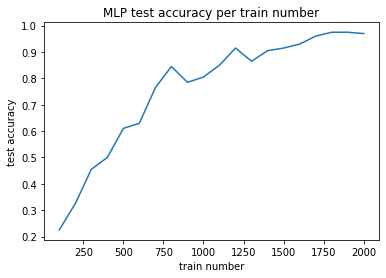

In [16]:
plt.plot(range(100, 2100, 100), mlp_test_accuracy)
plt.title('MLP test accuracy per train number')
plt.xlabel('train number')
plt.ylabel('test accuracy')
plt.show()

## III. Convolutional Neural Network (CNN)
### Convolutional Neural Network using Pytorch with below conditions

#### CNN1
> a. architecture : Conv(1,14,12,0) - MaxPool(21) - ReLU - Linear(7)  
> - Conv(m, n, k, p) : m input feature channels, n output feature channels, k kernel size, p padding number
> - MaxPool(s) : s kernel size
>
> b. Train set
> - D1 = tetris_dataset(N=2000, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
> - D2 = tetris_dataset(N=500, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
> - D3 = tetris_dataset(N=100, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
>
> c. Test set
> - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)
> 
> d. Epochs
> - 200 for training on D1
> - 400 for training on D2
> - 800 for training on D3
>
> e. Loss function = CrossEntropyLoss(reduction='mean')  
> f. Optimizer = AdaGrad(learning_rate=0.05)

- Plot CNN1 test accuracy per train number

#### CNN2
> a. architecture : Conv(1,5,3,1) - MaxPool(2) - ReLU - Conv(5,10,3,1) - MaxPool(2) - ReLU - Conv(10,10,3,1) - MaxPool(2) - ReLU - Conv(10,10,3,1) - MaxPool(2) - ReLU - Conv(10,10,3,1) - MaxPool(2) - ReLU - Linear(10) - ReLU - Linear(7)  
> 
> b. Train set
> - D1 = tetris_dataset(N=2000, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
> - D2 = tetris_dataset(N=500, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
> - D3 = tetris_dataset(N=100, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
>
> c. Test set
> - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)
> 
> d. Epochs
> - 200 for training on D1
> - 400 for training on D2
> - 800 for training on D3
>
> e. Loss function = CrossEntropyLoss(reduction='mean')  
> f. Optimizer = AdaGrad(learning_rate=0.05)
    
- Measure test accuracies for E1 after training CNN2 on D1

In [17]:
class TetrisCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 14, kernel_size=12, padding=0)
        self.fc1 = nn.Linear(14, 7)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, img_size, img_size)
        x = F.relu(F.max_pool2d(self.conv1(x), 21))
        x = x.view(batch_size, 14)
        logits = self.fc1(x)
        return logits
    
    
class TetrisCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 7)

    def forward(self, x):
        x = x.view(-1, 1, img_size, img_size)
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, img_size, img_size)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = F.relu(F.max_pool2d(self.conv5(x), 2))
        x = x.view(batch_size, 10)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

In [18]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 200
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, train_dataset=D1, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:0.04436814785003662, Train Accuracy:1.0
Epoch:50, Loss:0.0002176284760935232, Train Accuracy:1.0
Epoch:100, Loss:9.393692016601562e-05, Train Accuracy:1.0
Epoch:150, Loss:5.826949927723035e-05, Train Accuracy:1.0
Epoch:200, Loss:4.138946678722277e-05, Train Accuracy:1.0
1.0


In [19]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 400
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, train_dataset=D2, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:0.23397807776927948, Train Accuracy:1.0
Epoch:50, Loss:0.000720763229764998, Train Accuracy:1.0
Epoch:100, Loss:0.0003137350140605122, Train Accuracy:1.0
Epoch:150, Loss:0.0001959562359843403, Train Accuracy:1.0
Epoch:200, Loss:0.00014083385758567601, Train Accuracy:1.0
Epoch:250, Loss:0.00010986327833961695, Train Accuracy:1.0
Epoch:300, Loss:8.971690840553492e-05, Train Accuracy:1.0
Epoch:350, Loss:7.562637620139867e-05, Train Accuracy:1.0
Epoch:400, Loss:6.523132469737902e-05, Train Accuracy:1.0
1.0


In [20]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 800
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, train_dataset=D3, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:0.6414734125137329, Train Accuracy:0.75
Epoch:50, Loss:0.0011703968048095703, Train Accuracy:1.0
Epoch:100, Loss:0.000490593898575753, Train Accuracy:1.0
Epoch:150, Loss:0.0002999544085469097, Train Accuracy:1.0
Epoch:200, Loss:0.00021264553652144969, Train Accuracy:1.0
Epoch:250, Loss:0.00016341209993697703, Train Accuracy:1.0
Epoch:300, Loss:0.00013184547424316406, Train Accuracy:1.0
Epoch:350, Loss:0.00010962485976051539, Train Accuracy:1.0
Epoch:400, Loss:9.34600830078125e-05, Train Accuracy:1.0
Epoch:450, Loss:8.144378807628527e-05, Train Accuracy:1.0
Epoch:500, Loss:7.162093970691785e-05, Train Accuracy:1.0
Epoch:550, Loss:6.413459777832031e-05, Train Accuracy:1.0
Epoch:600, Loss:5.803108069812879e-05, Train Accuracy:1.0
Epoch:650, Loss:5.283355858409777e-05, Train Accuracy:1.0
Epoch:700, Loss:4.8351288569392636e-05, Train Accuracy:1.0
Epoch:750, Loss:4.472732689464465e-05, Train Accuracy:1.0
Epoch:800, Loss:4.158019874012098e-05, Train Accuracy:1.0
1.0


In [21]:
img_size = 32
summary(tetris_cnn1, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 21, 21]           2,030
            Linear-2                    [-1, 7]             105
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [22]:
cnn1_test_accuracy = []

for i in range(100, 2100, 100):
    print('')
    print('**** Train number : {} ****'.format(i))
    train_num = i
    D = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

    tetris_cnn1 = TetrisCNN1()
    tetris_cnn1.to(device)
    learning_rate = 0.05
    optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')

    total_epoch = 400000//i
    train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, train_dataset=D1, total_epoch=total_epoch)

    accuracy = evaluate(model=tetris_cnn1, criterion=criterion, test_dataset=E)
    cnn1_test_accuracy.append(accuracy)


**** Train number : 100 ****
Epoch:1, Loss:0.05162205547094345, Train Accuracy:1.0
Epoch:50, Loss:0.00045578478602692485, Train Accuracy:1.0
Epoch:100, Loss:0.0002142190933227539, Train Accuracy:1.0
Epoch:150, Loss:0.00013861656771041453, Train Accuracy:1.0
Epoch:200, Loss:0.0001024961457005702, Train Accuracy:1.0
Epoch:250, Loss:8.068084571277723e-05, Train Accuracy:1.0
Epoch:300, Loss:6.647109694313258e-05, Train Accuracy:1.0
Epoch:350, Loss:5.626678466796875e-05, Train Accuracy:1.0
Epoch:400, Loss:4.8351288569392636e-05, Train Accuracy:1.0
Epoch:450, Loss:4.2390824091853574e-05, Train Accuracy:1.0
Epoch:500, Loss:3.7670135498046875e-05, Train Accuracy:1.0
Epoch:550, Loss:3.4046173823298886e-05, Train Accuracy:1.0
Epoch:600, Loss:3.089904930675402e-05, Train Accuracy:1.0
Epoch:650, Loss:2.8467178708524443e-05, Train Accuracy:1.0
Epoch:700, Loss:2.6178360712947324e-05, Train Accuracy:1.0
Epoch:750, Loss:2.4175644284696318e-05, Train Accuracy:1.0
Epoch:800, Loss:2.2649765014648438e-05

Epoch:800, Loss:2.0313262211857364e-05, Train Accuracy:1.0
Epoch:850, Loss:1.8978118532686494e-05, Train Accuracy:1.0
Epoch:900, Loss:1.7642974853515625e-05, Train Accuracy:1.0
Epoch:950, Loss:1.678466833254788e-05, Train Accuracy:1.0
Epoch:1000, Loss:1.5592575437040068e-05, Train Accuracy:1.0
Epoch:1050, Loss:1.4829635802016128e-05, Train Accuracy:1.0
Epoch:1100, Loss:1.411438006471144e-05, Train Accuracy:1.0
Epoch:1150, Loss:1.3303756531968247e-05, Train Accuracy:1.0
Epoch:1200, Loss:1.2540816896944307e-05, Train Accuracy:1.0
Epoch:1250, Loss:1.1968612852797378e-05, Train Accuracy:1.0
Epoch:1300, Loss:1.1587142580538057e-05, Train Accuracy:1.0

**** Train number : 400 ****
Epoch:1, Loss:0.08095058053731918, Train Accuracy:1.0
Epoch:50, Loss:0.0004201650735922158, Train Accuracy:1.0
Epoch:100, Loss:0.00018084049224853516, Train Accuracy:1.0
Epoch:150, Loss:0.00010771751112770289, Train Accuracy:1.0
Epoch:200, Loss:7.576942152809352e-05, Train Accuracy:1.0
Epoch:250, Loss:5.81741333007

Epoch:150, Loss:0.00014486312284134328, Train Accuracy:1.0
Epoch:200, Loss:0.00010654926154529676, Train Accuracy:1.0
Epoch:250, Loss:8.41140717966482e-05, Train Accuracy:1.0

**** Train number : 1600 ****
Epoch:1, Loss:0.05626232549548149, Train Accuracy:1.0
Epoch:50, Loss:0.0006251573795452714, Train Accuracy:1.0
Epoch:100, Loss:0.00028445720090530813, Train Accuracy:1.0
Epoch:150, Loss:0.00017895697965286672, Train Accuracy:1.0
Epoch:200, Loss:0.00012936591519974172, Train Accuracy:1.0
Epoch:250, Loss:0.0001004934310913086, Train Accuracy:1.0

**** Train number : 1700 ****
Epoch:1, Loss:0.03659037500619888, Train Accuracy:1.0
Epoch:50, Loss:0.00033452510251663625, Train Accuracy:1.0
Epoch:100, Loss:0.00015592575073242188, Train Accuracy:1.0
Epoch:150, Loss:0.00010054111771751195, Train Accuracy:1.0
Epoch:200, Loss:7.376670691883191e-05, Train Accuracy:1.0

**** Train number : 1800 ****
Epoch:1, Loss:0.040553558617830276, Train Accuracy:1.0
Epoch:50, Loss:0.0003504514752421528, Train

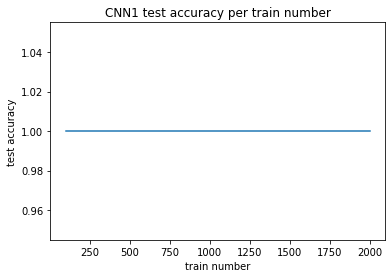

In [23]:
plt.plot(range(100, 2100, 100), cnn1_test_accuracy)
plt.title('CNN1 test accuracy per train number')
plt.xlabel('train number')
plt.ylabel('test accuracy')
plt.show()

In [24]:
tetris_cnn2 = TetrisCNN2()
tetris_cnn2.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn2.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

img_size = 32
summary(tetris_cnn2, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 32, 32]              50
            Conv2d-2           [-1, 10, 16, 16]             460
            Conv2d-3             [-1, 10, 8, 8]             910
            Conv2d-4             [-1, 10, 4, 4]             910
            Conv2d-5             [-1, 10, 2, 2]             910
            Linear-6                   [-1, 10]             110
            Linear-7                    [-1, 7]              77
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [25]:
total_epoch = 200
train(model=tetris_cnn2, optimizer=optimizer, criterion=criterion, train_dataset=D1, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn2, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:1.945844054222107, Train Accuracy:0.2
Epoch:50, Loss:0.00010237693641101941, Train Accuracy:1.0
Epoch:100, Loss:3.924369957530871e-05, Train Accuracy:1.0
Epoch:150, Loss:2.2220610844669864e-05, Train Accuracy:1.0
Epoch:200, Loss:1.5735626220703125e-05, Train Accuracy:1.0
1.0


## IV. Properties of CNNs

#### Conditions
> - Train set
>    - D4 = tetris_dataset(N=1000, batch_size=20, random_position=False, random_scale=False, random_rotation=False)
> - Test set
>    - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)
>
> - random_scale = True : block_sizes are uniformly selected from [4, 8, 12]
> - random_rotation = True : rotations are uniformly selected from [0, 90, 180, 270]

- Confirm that CNN is more translation-invariant than MLP by comparing test accuracies of TetrisCNN1 to TetrisMLP model
- Verify that CNN1 model is sensitive to scale and rotation

In [26]:
batch_size = 20
random_position = False
random_scale = False
random_rotation = False

train_num = 1000
D4 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

In [27]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 600
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=D4, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:0.0034149407874792814, Train Accuracy:1.0
Epoch:50, Loss:3.1137467885855585e-05, Train Accuracy:1.0
Epoch:100, Loss:1.3875961485609878e-05, Train Accuracy:1.0
Epoch:150, Loss:8.916855222196318e-06, Train Accuracy:1.0
Epoch:200, Loss:6.341934295051033e-06, Train Accuracy:1.0
Epoch:250, Loss:5.0067901611328125e-06, Train Accuracy:1.0
Epoch:300, Loss:3.862381163344253e-06, Train Accuracy:1.0
Epoch:350, Loss:3.52859501617786e-06, Train Accuracy:1.0
Epoch:400, Loss:2.8133392788731726e-06, Train Accuracy:1.0
Epoch:450, Loss:2.47955313170678e-06, Train Accuracy:1.0
Epoch:500, Loss:2.19345088225964e-06, Train Accuracy:1.0
Epoch:550, Loss:2.098083541568485e-06, Train Accuracy:1.0
Epoch:600, Loss:1.6689300537109375e-06, Train Accuracy:1.0
0.2


In [28]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 400
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, train_dataset=D4, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, test_dataset=E1)
print(accuracy)

Epoch:1, Loss:0.15807966887950897, Train Accuracy:1.0
Epoch:50, Loss:0.0006162643549032509, Train Accuracy:1.0
Epoch:100, Loss:0.0002756357134785503, Train Accuracy:1.0
Epoch:150, Loss:0.00017313957505393773, Train Accuracy:1.0
Epoch:200, Loss:0.00012483596219681203, Train Accuracy:1.0
Epoch:250, Loss:9.698867506813258e-05, Train Accuracy:1.0
Epoch:300, Loss:7.896423630882055e-05, Train Accuracy:1.0
Epoch:350, Loss:6.637573096668348e-05, Train Accuracy:1.0
Epoch:400, Loss:5.726814197259955e-05, Train Accuracy:1.0
0.9199999999999999


In [29]:
batch_size = 20
random_position = True
random_scale = True
random_rotation = True

train_num = 2000
D0 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

test_num = 200
E0 = make_tetris_dataset(test_num, batch_size, random_position, random_scale, random_rotation)

In [30]:
cnn1_test_accuracy = []

for i in range(100, 2100, 100):
    print('')
    print('**** Train number : {} ****'.format(i))
    
    train_num = i
    D = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

    tetris_cnn1 = TetrisCNN1()
    tetris_cnn1.to(device)
    learning_rate = 0.05
    optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')

    total_epoch = 400000//i
    train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, train_dataset=D0, total_epoch=total_epoch)

    accuracy = evaluate(model=tetris_cnn1, criterion=criterion, test_dataset=E0)
    cnn1_test_accuracy.append(accuracy)


**** Train number : 100 ****
Epoch:1, Loss:1.4051411151885986, Train Accuracy:0.45
Epoch:50, Loss:0.13878867030143738, Train Accuracy:1.0
Epoch:100, Loss:0.061084192246198654, Train Accuracy:1.0
Epoch:150, Loss:0.03463824838399887, Train Accuracy:1.0
Epoch:200, Loss:0.022704917937517166, Train Accuracy:1.0
Epoch:250, Loss:0.016386782750487328, Train Accuracy:1.0
Epoch:300, Loss:0.012703550048172474, Train Accuracy:1.0
Epoch:350, Loss:0.010314524173736572, Train Accuracy:1.0
Epoch:400, Loss:0.008651459589600563, Train Accuracy:1.0
Epoch:450, Loss:0.00741078844293952, Train Accuracy:1.0
Epoch:500, Loss:0.006468856241554022, Train Accuracy:1.0
Epoch:550, Loss:0.005730652716010809, Train Accuracy:1.0
Epoch:600, Loss:0.005106675438582897, Train Accuracy:1.0
Epoch:650, Loss:0.004586458206176758, Train Accuracy:1.0
Epoch:700, Loss:0.004146599676460028, Train Accuracy:1.0
Epoch:750, Loss:0.0037832497619092464, Train Accuracy:1.0
Epoch:800, Loss:0.003457617713138461, Train Accuracy:1.0
Epoch:8

Epoch:950, Loss:0.004455995745956898, Train Accuracy:1.0
Epoch:1000, Loss:0.004191589541733265, Train Accuracy:1.0
Epoch:1050, Loss:0.003952157683670521, Train Accuracy:1.0
Epoch:1100, Loss:0.00373668665997684, Train Accuracy:1.0
Epoch:1150, Loss:0.0035411478020250797, Train Accuracy:1.0
Epoch:1200, Loss:0.003366315271705389, Train Accuracy:1.0
Epoch:1250, Loss:0.0032079280354082584, Train Accuracy:1.0
Epoch:1300, Loss:0.0030630528926849365, Train Accuracy:1.0

**** Train number : 400 ****
Epoch:1, Loss:1.6172853708267212, Train Accuracy:0.4
Epoch:50, Loss:0.217838853597641, Train Accuracy:1.0
Epoch:100, Loss:0.11658243089914322, Train Accuracy:1.0
Epoch:150, Loss:0.07240068912506104, Train Accuracy:1.0
Epoch:200, Loss:0.05150710418820381, Train Accuracy:1.0
Epoch:250, Loss:0.039260197430849075, Train Accuracy:1.0
Epoch:300, Loss:0.03110119141638279, Train Accuracy:1.0
Epoch:350, Loss:0.025540243834257126, Train Accuracy:1.0
Epoch:400, Loss:0.02146320976316929, Train Accuracy:1.0
Epoch

Epoch:200, Loss:0.027926910668611526, Train Accuracy:1.0
Epoch:250, Loss:0.0205195602029562, Train Accuracy:1.0

**** Train number : 1700 ****
Epoch:1, Loss:1.497144341468811, Train Accuracy:0.45
Epoch:50, Loss:0.3691751956939697, Train Accuracy:0.95
Epoch:100, Loss:0.1927587240934372, Train Accuracy:0.95
Epoch:150, Loss:0.10633071511983871, Train Accuracy:1.0
Epoch:200, Loss:0.06806913763284683, Train Accuracy:1.0

**** Train number : 1800 ****
Epoch:1, Loss:1.3767716884613037, Train Accuracy:0.4
Epoch:50, Loss:0.23130960762500763, Train Accuracy:1.0
Epoch:100, Loss:0.11286699771881104, Train Accuracy:1.0
Epoch:150, Loss:0.07192216068506241, Train Accuracy:1.0
Epoch:200, Loss:0.05029059201478958, Train Accuracy:1.0

**** Train number : 1900 ****
Epoch:1, Loss:1.6081733703613281, Train Accuracy:0.5
Epoch:50, Loss:0.19750116765499115, Train Accuracy:0.95
Epoch:100, Loss:0.09300961345434189, Train Accuracy:1.0
Epoch:150, Loss:0.057402096688747406, Train Accuracy:1.0
Epoch:200, Loss:0.040

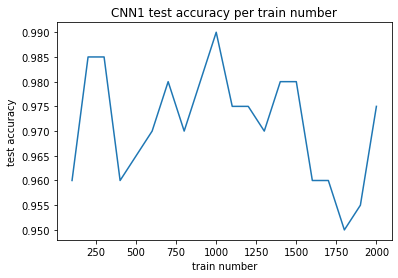

In [31]:
plt.plot(range(100, 2100, 100), cnn1_test_accuracy)
plt.title('CNN1 test accuracy per train number')
plt.xlabel('train number')
plt.ylabel('test accuracy')
plt.show()